In [1]:
import os

def clean_for_claude(result):
    if 'answer is' in result:
            idx = result.find('answer is')+len('answer is')
            key = result[idx:idx+30]
            return key
    if 'in:' in result:
        idx = result.find('in:')+len('in:')
        key = result[idx:idx+30]
        return key
    # result = result.replace('### Assistant:','')
    if any(i in result for i in ['could be anywhere','<none>','t determine', 'N/A', 'is unknown', 'cannot be determined', "enough information",'my final answer would be either']):
        return 'unknown'
    result = result.split('\n\n')
    if any(i in result[-1] for i in ['Hope', 'Does', 'Happy', 'et me know', 'Even though Liam told Noah differently', 'Explanation:']):
        result = result[:-1]
    if 'The key' in result[-1]:
        result = result[:-1]
    key = result[-1]
    key = key.split('\n')[-1]
    if all([i not in key[-30:] for i in ['red_', 'blue_', 'green_']]):
        if 'Which is what' in key or 'This is because' in key:
            return result[-2]
        return key
    return key[-30:]

def clean_for_gpt(result):
    if len(result)<30:
        return result
    if 'answer is' in result:
        idx = result.find('answer is')+len('answer is')
        key = result[idx:idx+30]
        return key
    if any(i in result for i in ['Insufficient information','None of the options','cannot answer','cannot provide any information','cannot know','could be anywhere','<none>','t determine', 'N/A', 'is unknown', 'cannot be determined', "enough information",'my final answer would be either']):
        return 'unknown'
    key = result.split('\n')[-2:]
    return key[-1]

# def clean_for_guanaco(result):
#     result = result.replace('### Assistant:','')
#     if len(result)<30:
#         return result
#     if 'answer is' in result:
#         idx = result.find('answer is')+len('answer is')
#         key = result[idx:idx+30]
#         return key
#     if any(i in result for i in ['Insufficient information','None of the options','cannot answer','cannot provide any information','cannot know','could be anywhere','<none>','t determine', 'N/A', 'is unknown', 'cannot be determined', "enough information",'my final answer would be either']):
#         return 'unknown'
#     key = result.split('\n')[-2:]
#     if 'Based on the' in key[-1] or 'This is because' in key[-1]:
#         return key[-2]
#     return key[-1]

def clean_for_guanaco(result):
    return result[-150:]

def eval(result_folder):
    print(result_folder)
    acc = {}
    ans_folder = "data_ToMh_old"
    def clean(result):
        if 'Claude' in result_folder:
            return clean_for_claude(result)
        if 'gpt' in result_folder:
            return clean_for_gpt(result)
        return clean_for_guanaco(result)
    
    def correct(result, choice, ans):
        if any([i in result for i in ['red', 'blue', 'green']]):
            if ans in result.lower():
                return 1
            else:
                return 0
        if choice in result:
            return 1
        return 0

    have = 0
    # Iterate over all files and subdirectories within the root folder
    for folder_name, subfolders, filenames in os.walk(result_folder):
        for filename in filenames:
            if filename.endswith(".txt"):
                    ans_folder_name = folder_name.replace(result_folder, ans_folder)
                    have += 1
                    with open(os.path.join(ans_folder_name, filename), "r") as f:
                        output = f.read()
                        ans = output[output.find('Answer: '):]
                        ans = ans[:ans.find('\n')]
                        ans = ans.split()[-1]
                        choice = output[output.find('Choices:'):]
                        choice = choice[choice.find(ans)-3]
                        ans = ans.replace('_',' ')

                    with open(os.path.join(folder_name, filename), "r") as f:
                        result = f.read()
                        result = clean(result)
                        result = result.replace('_',' ')
                        # print(result)
                        acc_path  = os.path.join(folder_name, filename).replace(result_folder,'')       
                    acc[acc_path] = correct(result, choice, ans)
    print(have)
    # joint acc
    for key, value in acc.items():
        if value == 0:
            index = 2+key.find('r_')
            o = int(key[index]) + 1
            for i in range(o, 5):
                # print('r_'+key[index])
                new_k = key.replace('r_'+key[index], 'r_'+str(i))
                # print(key, new_k)
                acc[new_k] = 0
    # print(acc)
    
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    def plot(data, title):
        # Create one subplots
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))

        # Create a custom colormap from green (1) to white (0)
        colors = [(1, 1, 1),(0, 0.4, 0)]
        cmap = LinearSegmentedColormap.from_list('darkgreen_to_white', colors)

        # Plot the first figure
        axs.imshow(data, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        axs.set_title(title)
        
        # Add text in the center of each block
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                text = axs.text(j, i, data[i, j], ha='center', va='center', color='black')

        # Show the figures
        plt.show()

    def get_acc(check_list):
        cnt = 0.001
        cor = 0
        for key, value in acc.items():
            # print(key)
            # print([i in key for i in check_list])
            if all([i in key for i in check_list]):
                cnt += 1
                cor += value
                # print(cor)
        # return cnt
        return round(cor / cnt, 2)
    
    # draw the picture
    import numpy as np
    for i in ['CoT', 'MC']:
        for j in ['Tell', 'No_Tell']:
            data = np.zeros((3,5))
            # print(data)
            for k in range(5):
                for l in range(3):
                    # print(data[l][k])
                    o = 'order_{}'.format(k)
                    le = 'length_{}'.format(l+1)
                    data[l][k] = get_acc([i, j, o, le])
            plot(data, i+j)
            # print(data.mean())

result_Claude-instant
1200


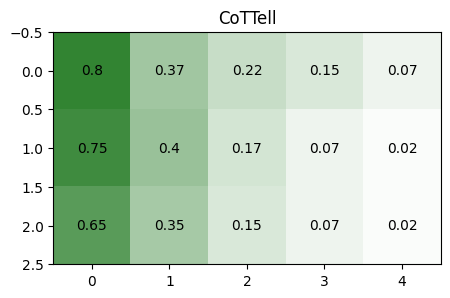

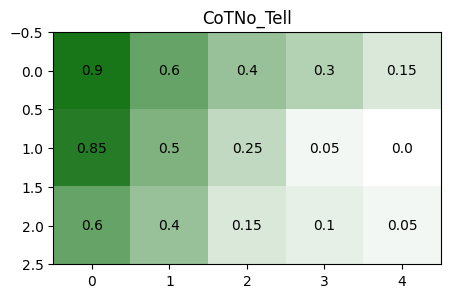

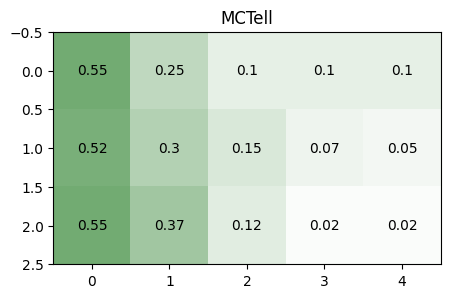

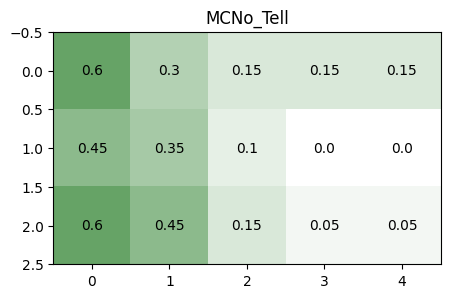

In [4]:
# result_folder = 'API_responses'
# result_folder = 'result_gpt-3.5-turbo-v1' # Let's think step by step.
# result_folder = 'result_gpt-3.5-turbo-v0' # first break down the question. Then solve the question step by step.
result_folder = 'result_Claude-instant'
# result_folder = "result_llama65b-v1"
eval(result_folder)